In [1]:
import sys 
sys.path.append("..")

In [2]:
import umap
import operator
from xgboost import XGBClassifier
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from ksvd import ApproximateKSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from comon import creatMas, plot_ssp, creat_win_sum_data
from plots_report import plot_metrics

Using TensorFlow backend.


In [3]:
ocean = 'BarentsSea'

In [4]:
files = ['CZ1.txt', 'CZ2.txt', 'CZ3.txt', 'CZ4.txt','CZ5.txt', 'CZ6.txt',
         'CZ7.txt','CZ8.txt','CZ9.txt','CZ10.txt', 'CZ11.txt','CZ12.txt']

CZ = []
for file in files:
    with open('{0}/{1}'.format(ocean, file), 'r') as f:
        line = f.readlines()
        cz=creatMas(line)
    CZ.append(cz)
    
_, N_cord = cz.shape

with open('{}/zs.txt'.format(ocean), 'r') as f:
    line = f.readlines()
    line.remove(line[N_cord])
zs = [-int(a) for a in line]

In [5]:
def AEncoder(input_dim, latent_dim):
    hidden_layer = int(input_dim * 0.8)
    
    inputs = Input(shape=(input_dim,))
    inp_layar1 = Dense(hidden_layer, activation='softplus',kernel_initializer='he_normal')(inputs)
    #np_layar1 = Dropout(0.1)(inp_layar1)
    
    encoded = Dense(latent_dim, activation='softplus', kernel_initializer='he_normal')(inp_layar1)
    
    dec_lay = Dense(hidden_layer,activation='linear', kernel_initializer='he_normal')(encoded)
    #dec_lay = Dropout(0.1)(dec_lay)
    decoded = Dense(input_dim,activation='linear', kernel_initializer='he_normal')(dec_lay)
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [6]:
def researcher_pca(CLF,X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10]):
    scores = []
    for n in n_comp:
        dec = PCA(n_components=n)
        clf = CLF()
        pipe = Pipeline([('dec', dec), ('clf', clf)])
        pipe.fit(X_train, Y_train)
        predict = pipe.predict(X_test)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores



def researcher_ksvd(CLF, X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10]):
    scores = []
    for n in n_comp:
        ksvd = ApproximateKSVD(n_components=n, transform_n_nonzero_coefs=n//2)
        meantr = np.mean(X_train,axis=0)
        dictionary = ksvd.fit(X_train - meantr).components_
        gamma_train = ksvd.transform(X_train - meantr)
        gamma_test = ksvd.transform(X_test - meantr)
        
        clf = CLF()
        clf.fit(gamma_train, Y_train)
        predict = clf.predict(gamma_test)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores


def researcher_ae(CLF, X_train, Y_train, X_test, Y_test, n_comp=[3,5,7,10]):
    scores = []
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    for n in n_comp:
        autoencoder_std, encoder_std = AEncoder(N_cord, n)
        autoencoder_std.fit(X_train_std, X_train_std,
                epochs=750,
                batch_size=64,
                shuffle=True, verbose=0)
          
        test_embedding = encoder_std.predict(X_test_std)
        train_embedding = encoder_std.predict(X_train_std)
        
        clf = CLF()
        clf.fit(train_embedding, Y_train)
        predict = clf.predict(test_embedding)
        score = accuracy_score(Y_test, predict)
        scores.append(score)
    return scores

In [7]:
def plot_confusion_matrix(cm, classes=['winter', 'summer'],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_metrics(clf, X_train, X_test, y_train, y_test):
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)
    print('Accuracy на тренировочных данных: {}'.format(accuracy_score(y_train, predict_train)))
    print('Accuracy на тестовых данных: {}'.format(accuracy_score(y_test, predict_test)))
    
    plot_confusion_matrix(confusion_matrix(y_train, predict_train), title='Confusion matrix для обучающих данных')
    plot_confusion_matrix(confusion_matrix(y_test, predict_test), title='Confusion matrix для тестовых данных')
    
def feature_importances(clf, size = (10,12), title_x = 'Важность координаты', title_y = 'Глубина', zs = zs):
    fi = clf.feature_importances_
    x = range(1,len(fi)+1)
    plt.figure(figsize=size)
    plt.barh(x, fi)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.yticks(x,list(map(str,zs)))
    plt.show()

In [48]:
winter_index, summer_index = [12, 1, 2], [6, 7, 8]
X, Y = creat_win_sum_data(CZ, winter_index, summer_index, N=200)
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, stratify=Y, random_state=0)

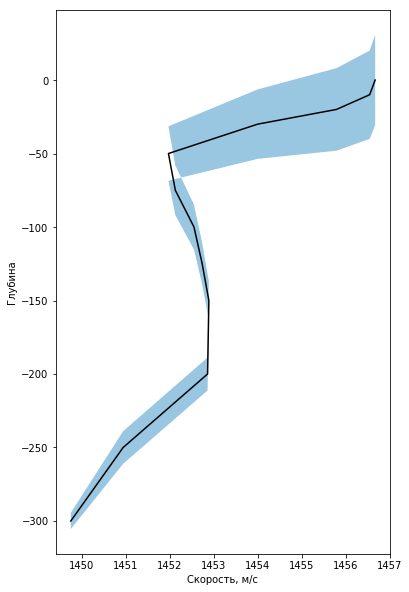

In [15]:
x  = np.array(X_train)
x_std = np.std(x, axis=0)
x_mean = np.mean(x, axis=0)
plt.figure(figsize=(6,10))
plt.plot(x_mean,zs, 'k')
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.fill_between(x_mean, zs - 3*x_std, zs + 3*x_std, alpha=0.4)
plt.show()

## LogisticRegression

In [16]:
clf = LogisticRegression()
param = [0.01, 0.1, 1, 10, 20, 30, 50, 70, 100, 120, 130]
param_grid = { 'C': param }

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'C': 10}

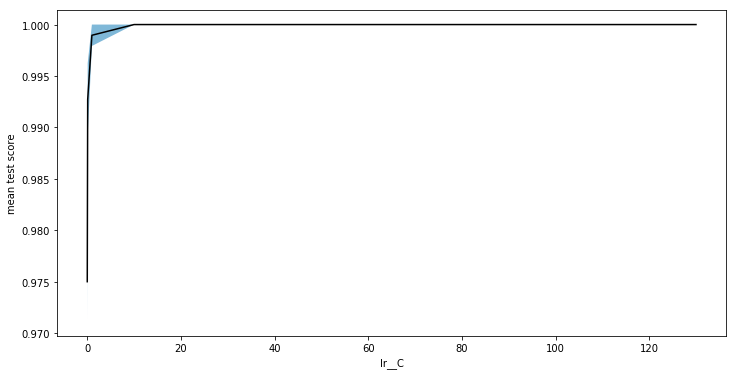

In [17]:
mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score/2, mean_scor + std_score/2, alpha=0.5)
plt.xlabel('lr__C')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9958333333333333


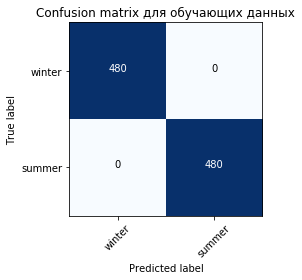

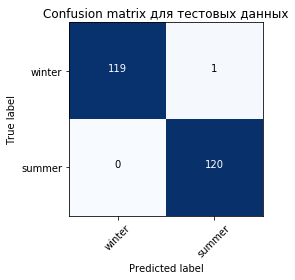

In [18]:
clf = LogisticRegression(C=20)
clf.fit(X_train, y_train)
print_metrics(clf, X_train, X_test, y_train, y_test)

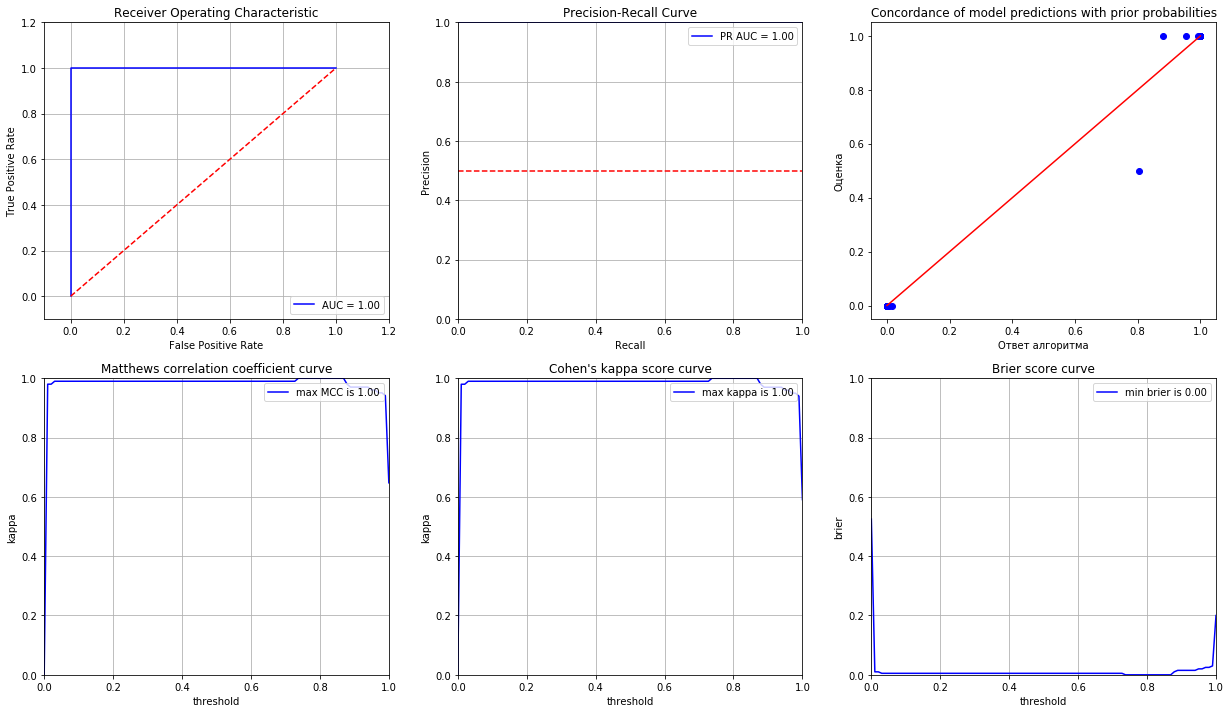

The rmse of model's prediction is: 0.0545
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 1.000 with threshold = 0.74
Max Matthews correlation coefficient is 1.000 with threshold = 0.74
Min Brier score is 0.000 with threshold = 0.74


In [19]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

**Важность координат**

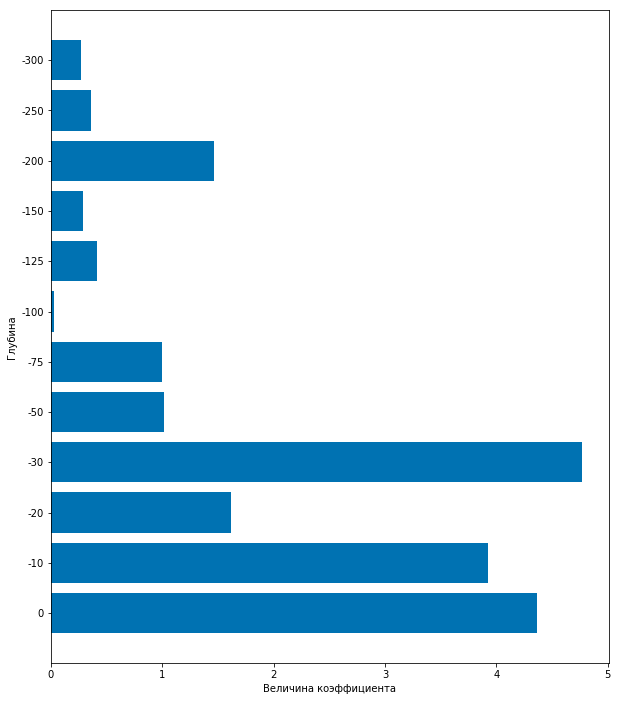

In [20]:
x = range(1,N_cord+1)
y = list(map(abs,clf.coef_[0]))
plt.figure(figsize=(10,12))
plt.barh(x, y)
plt.xlabel('Величина коэффициента')
plt.ylabel('Глубина')
plt.yticks(x,list(map(str,zs)))
plt.show()

## LogisticRegression + StandardScaler

In [21]:
std = StandardScaler()
clf = LogisticRegression()
pipe = Pipeline([('std', std), ('lg', clf)])

In [22]:
param = [0.01, 0.1, 1, 10, 20, 30, 50, 70, 100, 120, 130]
param_grid = { 'lg__C': param }
grd = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'lg__C': 70}

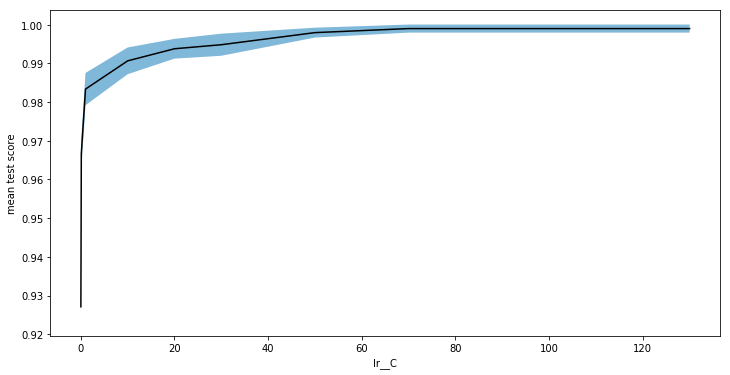

In [23]:
mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score/2, mean_scor + std_score/2, alpha=0.5)
plt.xlabel('lr__C')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9989583333333333
Accuracy на тестовых данных: 0.975


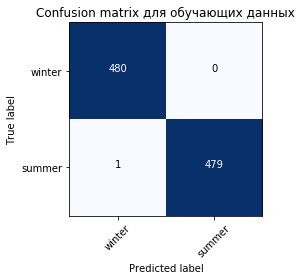

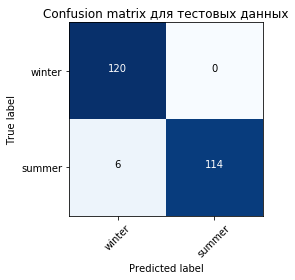

In [24]:
std = StandardScaler()
clf = LogisticRegression(C=30)
pipe = Pipeline([('std', std), ('lg', clf)])

pipe.fit(X_train, y_train)
print_metrics(pipe, X_train, X_test, y_train, y_test)

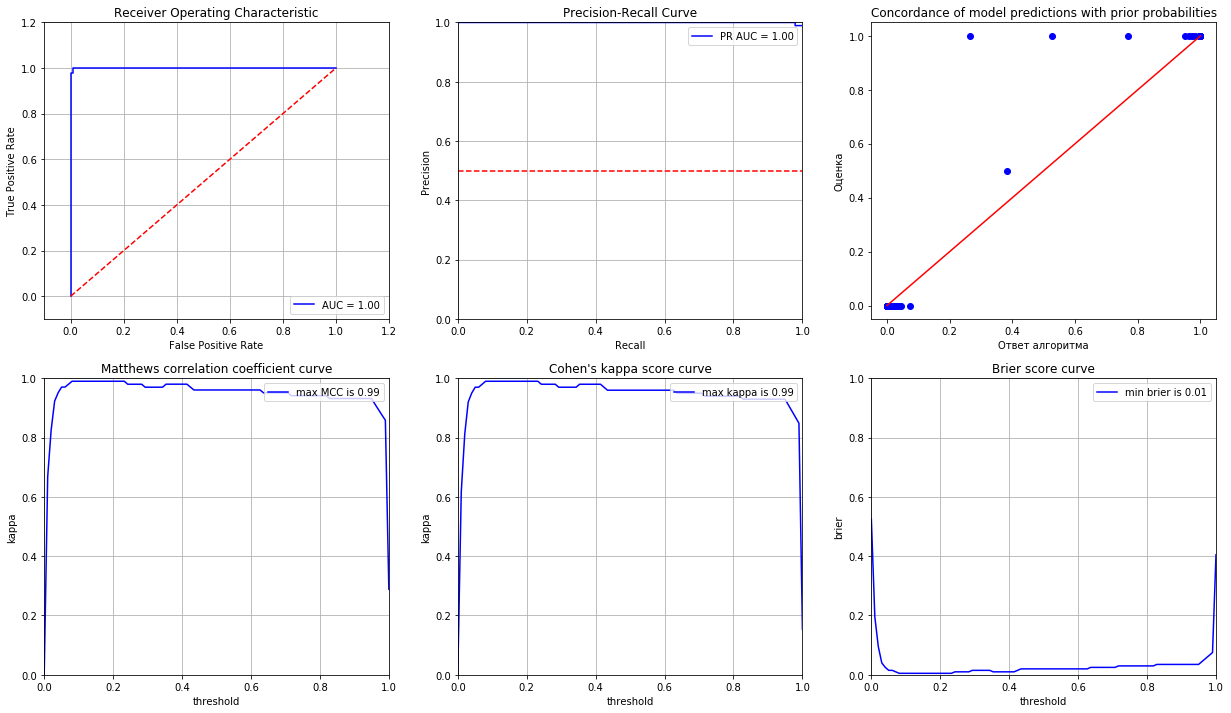

The rmse of model's prediction is: 0.1038
The Gini of model's prediction is: 0.9996
The ROC AUC of model's prediction is: 0.9998
The PR AUC of model's prediction is: 0.9998
Max Cohen's kappa is 0.990 with threshold = 0.08
Max Matthews correlation coefficient is 0.990 with threshold = 0.08
Min Brier score is 0.005 with threshold = 0.08


In [25]:
pr_prob = pipe.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

## LogisticRegression + PCA

**Зависимость точности классификации от числа компонент**

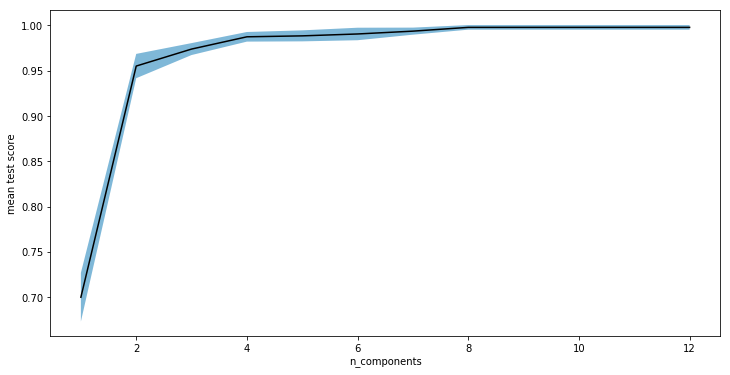

In [26]:
pca = PCA()
clf = LogisticRegression(C=1)
pipe = Pipeline([('pca', pca), ('lg', clf)])

param = list(range(1,N_cord+1))
param_grid = { 'pca__n_components': param }

grd = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)

grd.fit(X_train, y_train)

mean_scor = grd.cv_results_['mean_test_score']
std_score = grd.cv_results_['std_test_score']
plt.figure(figsize=(12,6))
plt.plot(param, grd.cv_results_['mean_test_score'], c='k')
plt.fill_between(param, mean_scor - std_score, mean_scor + std_score, alpha=0.5)
plt.xlabel('n_components')
plt.ylabel('mean test score')
plt.show()

Accuracy на тренировочных данных: 0.9989583333333333
Accuracy на тестовых данных: 0.975


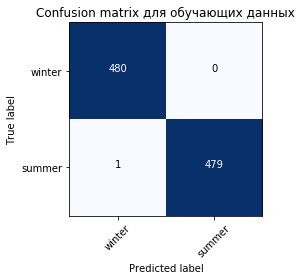

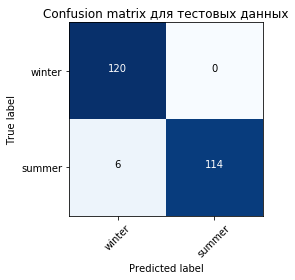

In [27]:
pca = PCA(n_components=10)
clf = LogisticRegression()
pipe = Pipeline([('pca', pca), ('lg', clf)])
pipe.fit(X_train, y_train)
print_metrics(pipe, X_train, X_test, y_train, y_test)

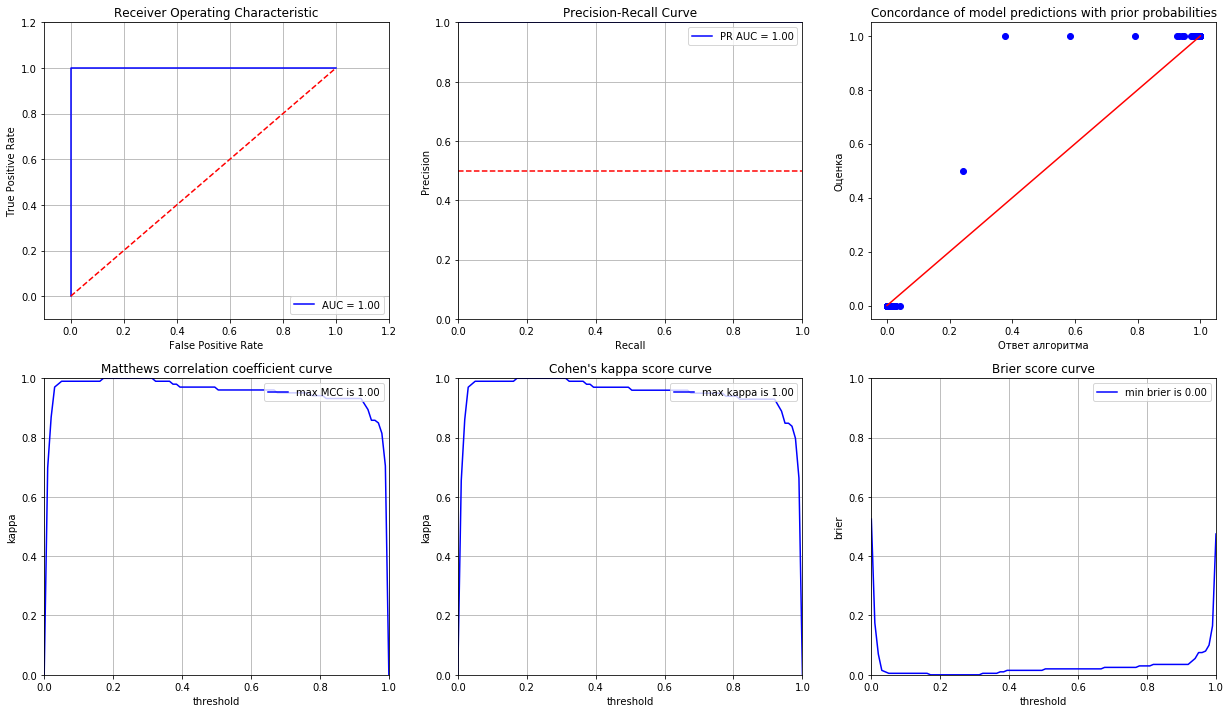

The rmse of model's prediction is: 0.0940
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 1.000 with threshold = 0.17
Max Matthews correlation coefficient is 1.000 with threshold = 0.17
Min Brier score is 0.000 with threshold = 0.17


In [28]:
pr_prob = pipe.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

In [29]:
researcher_pca(LogisticRegression, X_train, y_train, X_test, y_test)

[0.9625, 0.9666666666666667, 0.9666666666666667, 0.975]

In [30]:
researcher_ksvd(LogisticRegression, X_train, y_train, X_test, y_test)

[0.85, 0.9625, 0.9666666666666667, 0.9666666666666667]

In [31]:
researcher_ae(LogisticRegression, X_train, y_train, X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[0.8958333333333334, 0.95, 0.9583333333333334, 0.9583333333333334]

## RandomForestClassifier

In [32]:
clf = RandomForestClassifier()
param_grid = { 'n_estimators': [1, 5, 10, 20, 50, 75, 100, 150, 200, 300, 400, 500], 'min_samples_split' : [2, 3, 4] }

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(X_train, y_train)
grd.best_params_

{'min_samples_split': 2, 'n_estimators': 20}

In [33]:
clf = RandomForestClassifier(n_estimators=75,min_samples_split=3)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9791666666666666


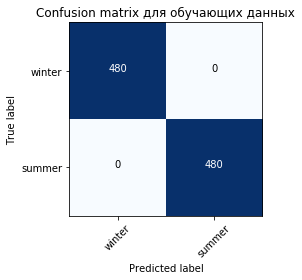

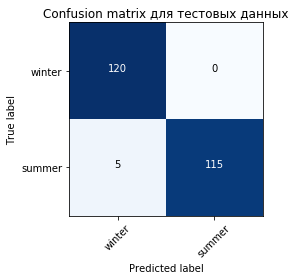

In [34]:
print_metrics(clf, X_train, X_test, y_train, y_test)

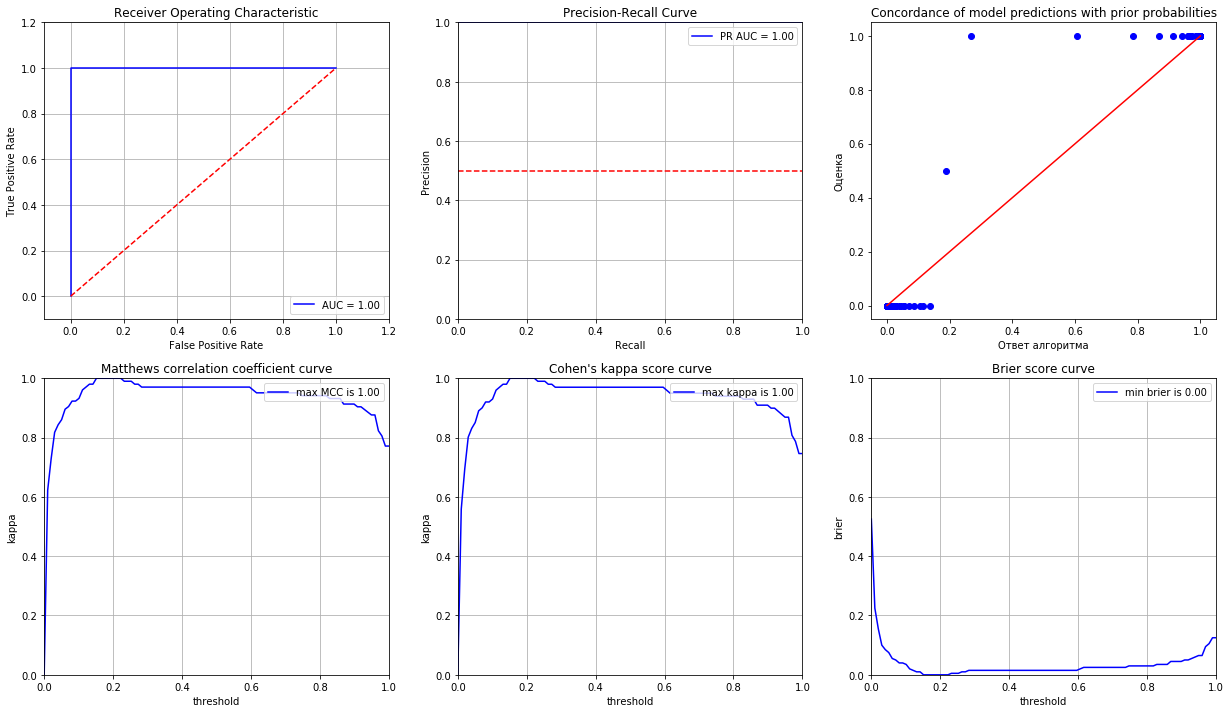

The rmse of model's prediction is: 0.1074
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 1.000 with threshold = 0.15
Max Matthews correlation coefficient is 1.000 with threshold = 0.15
Min Brier score is 0.000 with threshold = 0.15


In [35]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

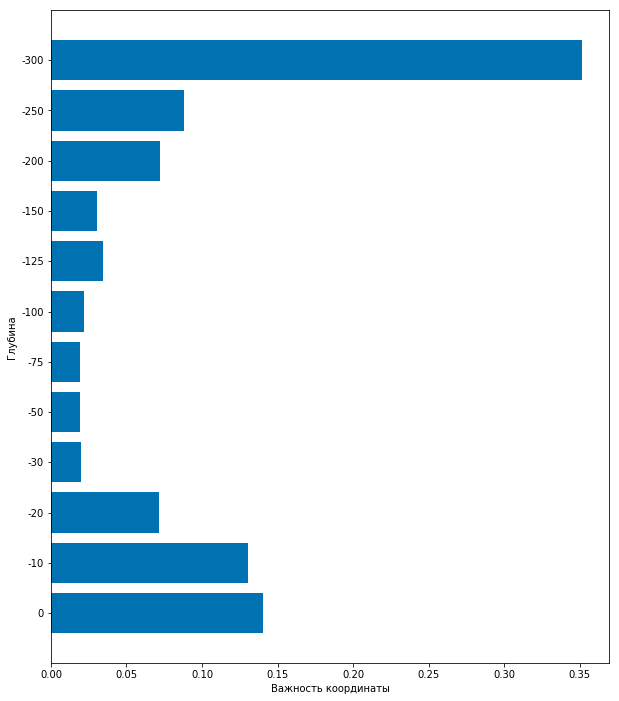

In [36]:
feature_importances(clf)

In [57]:
researcher_pca(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.9678571428571429,
 0.9916666666666667,
 0.9988095238095238,
 0.9988095238095238]

In [58]:
researcher_ksvd(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.8369047619047619,
 0.9773809523809524,
 0.9928571428571429,
 0.9940476190476191]

In [60]:
researcher_ae(RandomForestClassifier, X_train, y_train, X_test, y_test)

[0.75595238095238093,
 0.93095238095238098,
 0.94880952380952377,
 0.96309523809523812,
 0.98095238095238091]

## Бустинг

In [59]:
n_est = [100, 200, 500,700, 1000]
max_dep = [1,2,3]
lr = [0.01, 0.1, 0.5, 1]
clf = XGBClassifier()
param_grid = { 'n_estimators': n_est, 'max_depth':max_dep, 'learning_rate':lr}

grd = GridSearchCV(clf, param_grid, cv=5,
                      return_train_score=False)
grd.fit(np.array(X_train), y_train)
grd.best_params_

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 500}

Accuracy на тренировочных данных: 1.0
Accuracy на тестовых данных: 0.9958333333333333


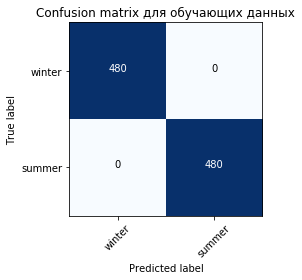

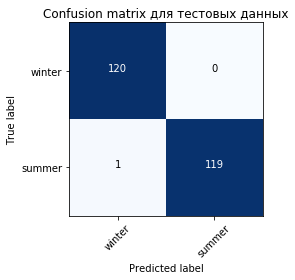

In [37]:
clf = XGBClassifier(learning_rate=0.5, max_depth=1, n_estimators=500)
clf.fit(np.array(X_train), y_train)
print_metrics(clf, X_train, X_test, y_train, y_test)

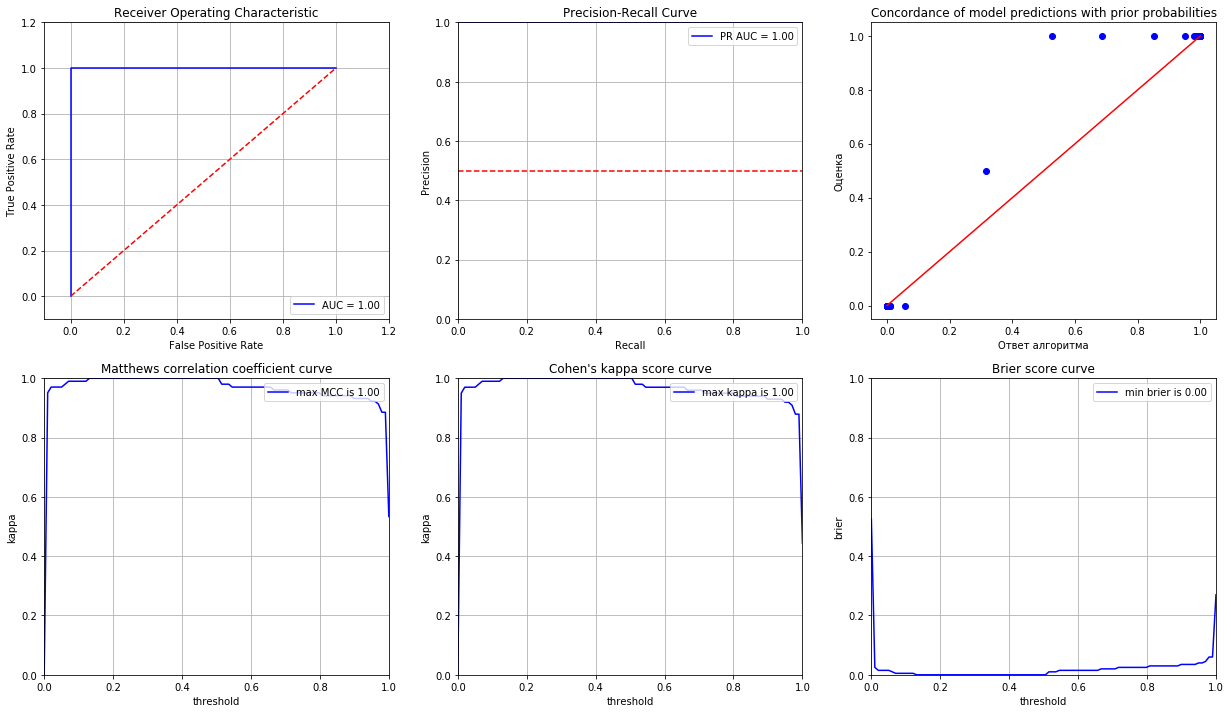

The rmse of model's prediction is: 0.0694
The Gini of model's prediction is: 1.0000
The ROC AUC of model's prediction is: 1.0000
The PR AUC of model's prediction is: 1.0000
Max Cohen's kappa is 1.000 with threshold = 0.13
Max Matthews correlation coefficient is 1.000 with threshold = 0.13
Min Brier score is 0.000 with threshold = 0.13


In [38]:
pr_prob = clf.predict_proba(X_test)[:,1]
N = len(y_test)
M = 100
n = int(N/M)
plot_metrics(np.array(y_test[:n*M]), pr_prob[:n*M],n=M)

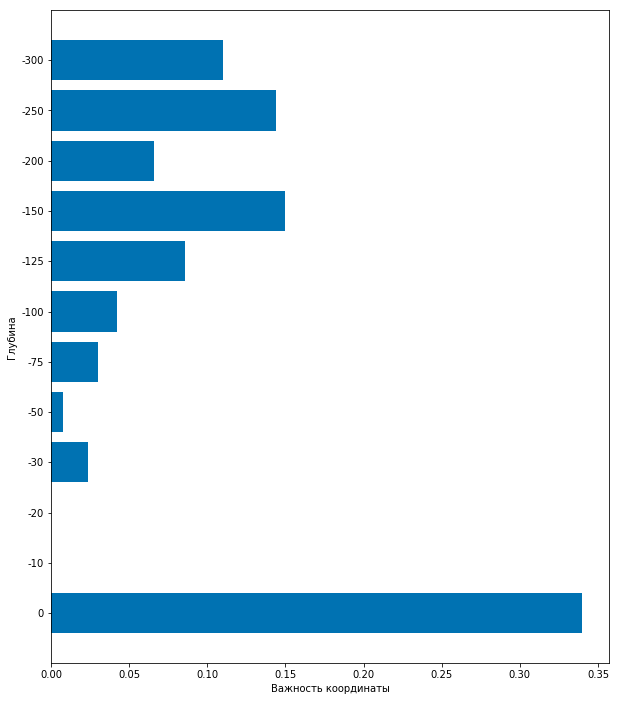

In [39]:
feature_importances(clf)

In [40]:
import shap
df = pd.DataFrame(X_train,columns=zs)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(df)

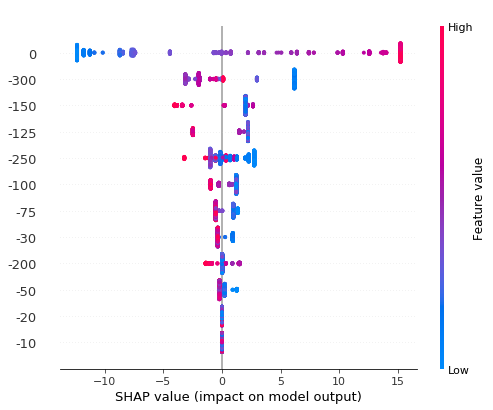

In [41]:
shap.summary_plot(shap_values, df)

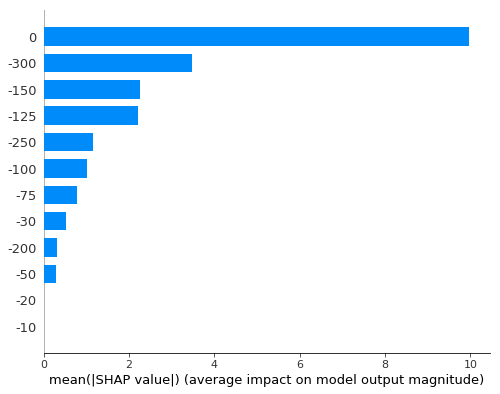

In [42]:
shap.summary_plot(shap_values, df, plot_type = "bar" )

In [43]:
researcher_pca(XGBClassifier, X_train, y_train, X_test, y_test)

[0.9666666666666667, 0.9791666666666666, 0.9875, 0.9916666666666667]

In [44]:
researcher_ksvd(XGBClassifier, X_train, y_train, X_test, y_test)

[0.8458333333333333, 0.9541666666666667, 0.9708333333333333, 0.9875]

In [45]:
researcher_ae(XGBClassifier, X_train, y_train, X_test, y_test)

[0.9916666666666667, 0.9875, 0.9833333333333333, 0.9916666666666667]

## Важность главных компонент

In [46]:
pca = PCA(n_components=10)
pca.fit(X_train)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


ksvd = ApproximateKSVD(n_components=10, transform_n_nonzero_coefs=7)
meantr = np.mean(X_train,axis=0)
dictionary = ksvd.fit(X_train - meantr).components_
gamma_train = ksvd.transform(X_train - meantr)

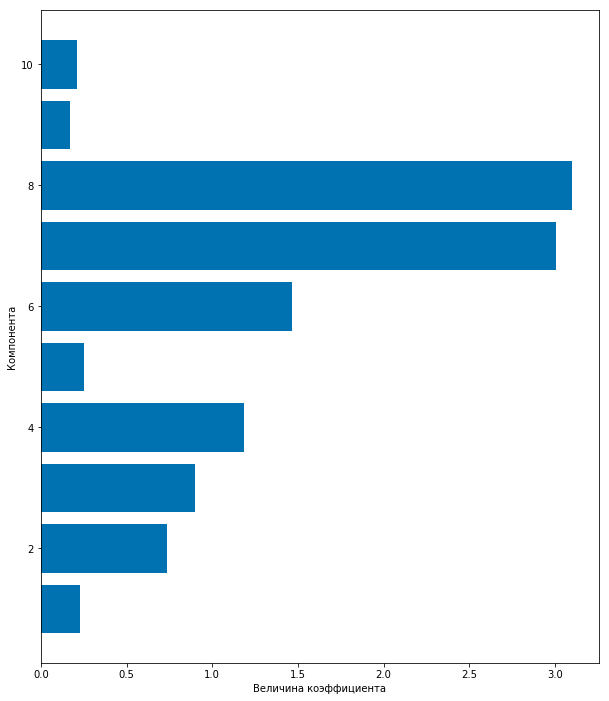

In [47]:
clf = LogisticRegression().fit(X_pca_train, y_train)
x = range(1,11)
y = list(map(abs,clf.coef_[0]))
plt.figure(figsize=(10,12))
plt.barh(x, y)
plt.xlabel('Величина коэффициента')
plt.ylabel('Компонента')
plt.show()

## Визуализация зима/лето

In [82]:
win_data = [X[i] for i in range(len(X)) if Y[i] == 0]
sum_data = [X[i] for i in range(len(X)) if Y[i] == 1]

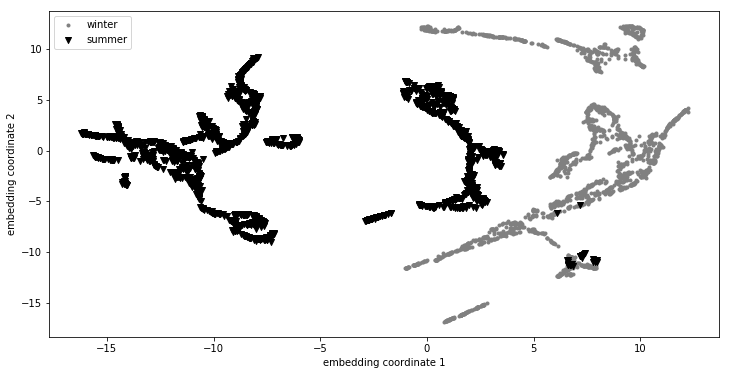

In [83]:
embedding = umap.UMAP()
embedding.fit(X)
win_emb = embedding.transform(win_data)
sum_emb = embedding.transform(sum_data)
plt.figure(figsize=(12,6))
plt.scatter(win_emb[:,0], win_emb[:,1], c = 'grey', label='winter', marker = ".")
plt.scatter(sum_emb[:,0], sum_emb[:,1], c = 'black', label = 'summer',marker =  "v")
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.legend()
plt.show()

## Визуализация по месяцам

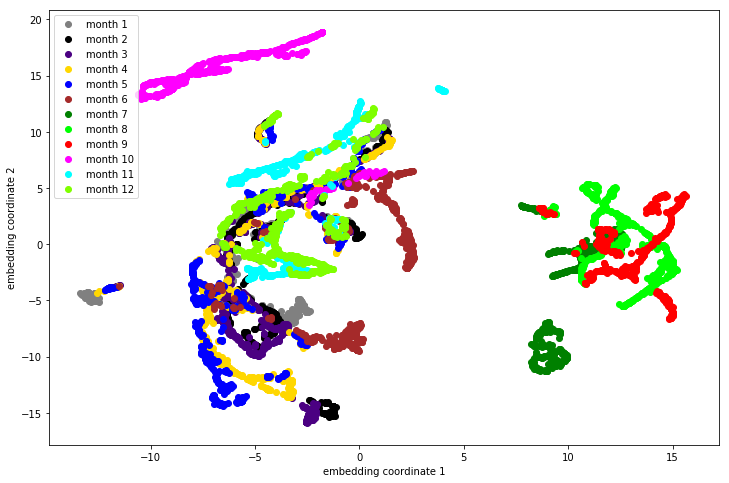

In [84]:
AllX = []
for x in CZ:
    AllX += list(x)
embedding.fit(AllX)

plt.figure(figsize=(12,8))
color = ['grey', 'black', 'indigo', 'gold', 'blue', 'brown', 'green', 'lime', 'red', 'fuchsia', 'cyan', 'chartreuse']
for i in range(12):
    x_emb = embedding.transform(CZ[i])
    plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
plt.legend()
plt.xlabel('embedding coordinate 1')
plt.ylabel('embedding coordinate 2')
plt.show()

**визуальная разделимость от колличества  компонент PCA**

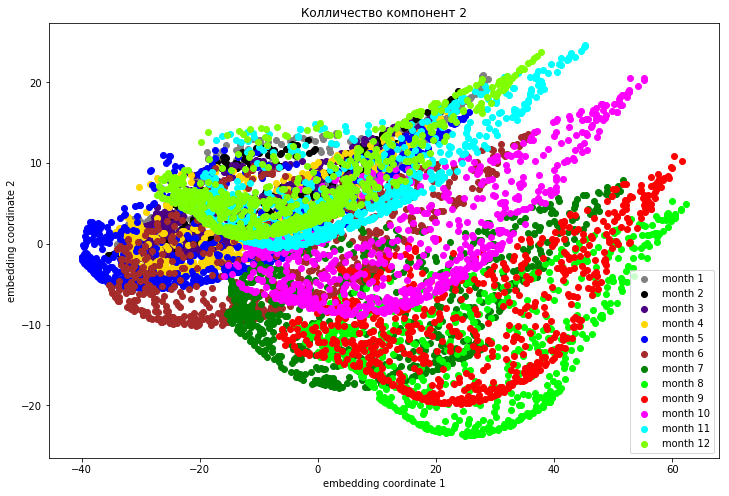

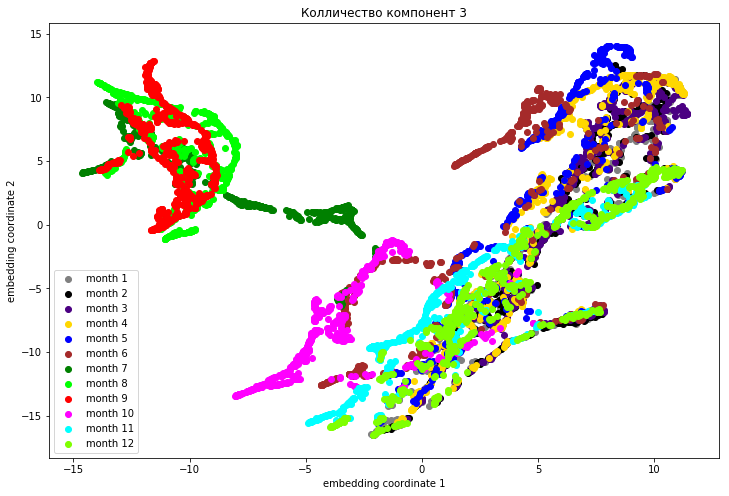

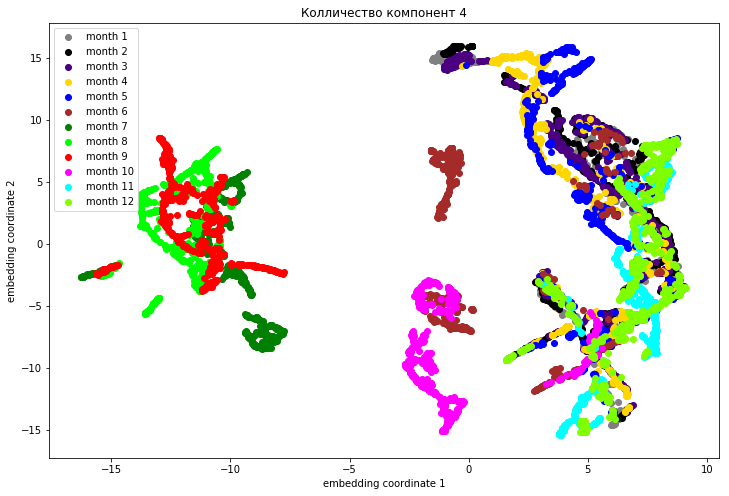

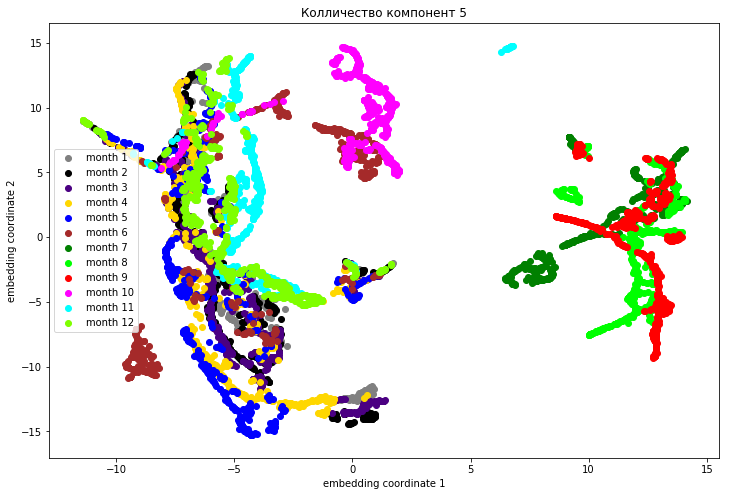

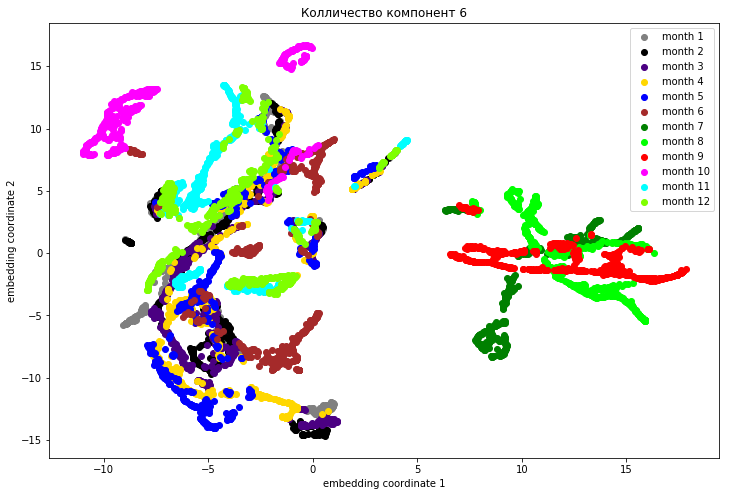

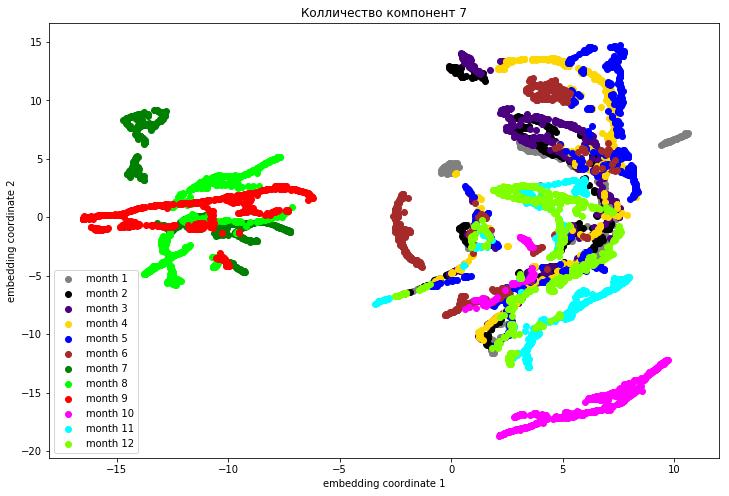

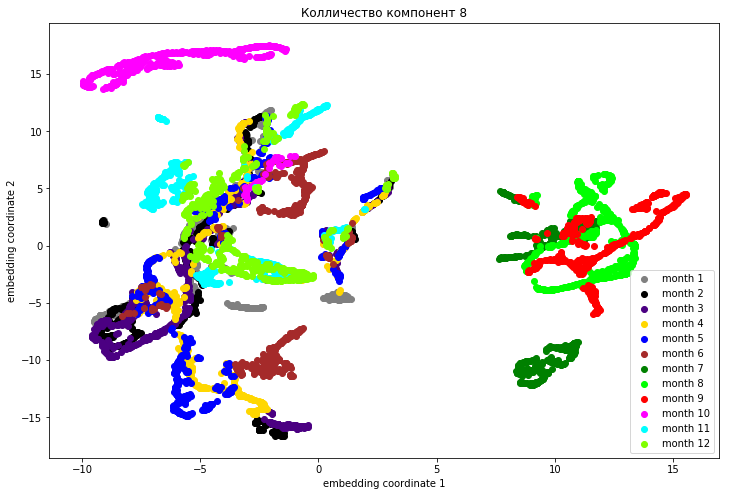

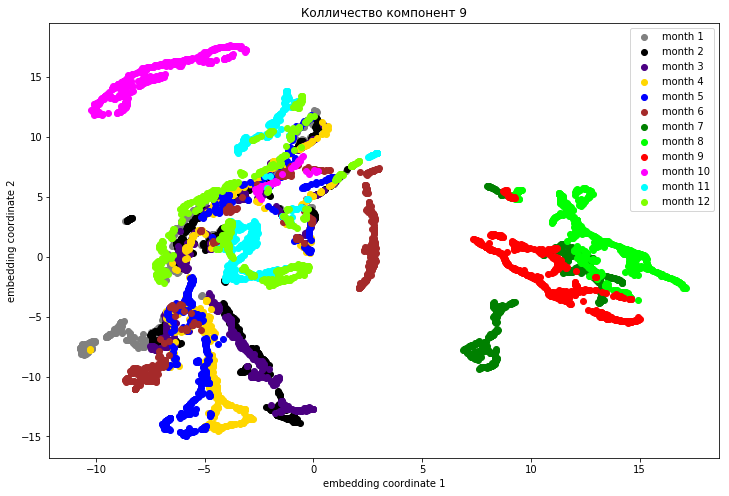

In [85]:
embedding = umap.UMAP()
for n_comp in range(2,10):
    pca = PCA(n_components=n_comp)
    AllX_red = pca.fit_transform(AllX)
    embedding.fit(AllX_red)
    plt.figure(figsize=(12,8))
    for i in range(12):
        if n_comp == 2: x_emb = pca.transform(CZ[i])
        else: x_emb = embedding.transform(pca.transform(CZ[i]))
        plt.scatter(x_emb[:,0], x_emb[:,1], label='month {}'.format(i+1), c=color[i])
        plt.title("Колличество компонент {}".format(n_comp))
        plt.legend()
    plt.xlabel('embedding coordinate 1')
    plt.ylabel('embedding coordinate 2')
    plt.show()